# GOAL: Let's make an alchemical structure and topology for ATP $\rightarrow$ 2AP

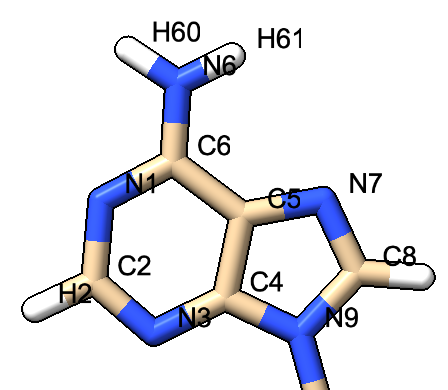

## Structure

First, we need to make a new amino NH2 group that is connected to the C2 atom, and a new H that is
connected to C6

In [104]:
# Here are simple container objects for a grofile, and atom lines in a grofile

import numpy as np

class GroFile(object):
    """a simple container object for a grofile."""
    
    def __init__(self, filename):
        """Initialize the GroFile object."""
        fin = open('ATP_GMX.gro','r')
        grolines = fin.readlines()
        fin.close()

        # sometimes the last line is a blank '\n' -- remove these
        while grolines[-1].strip() == '':
            grolines.pop()

        # get the non-atom line information
        self.box_line = grolines.pop()
        self.title_line  = grolines.pop(0)    # note: these still contain the ending '\n'
        self.natoms_line = grolines.pop(0)
        self.natoms = int((self.natoms_line).strip())

        # the remaining lines are either comments or atom lines, which we will store as 
        # a list of GromacsAtom() objects
        self.atoms = []
        for line in grolines:
            if line[0] != ';':
                self.atoms.append( GromacsAtom(line) )

        self.outlines = []   # to be filled later

    def add_atom(self, a):
        """Add a GromacsAtom() to the list of atoms."""
        self.atoms.append( a )
        self.natoms += 1
        self.natoms_line = f'{self.natoms}\n' 
        
        
    def build_atomnum_dict(func):
        def wrapper(self, name):
            self.atomnum = {}
            for a in self.atoms:
                self.atomnum[ (a.atomname).strip() ] = a.atomnum
            return func(self, name)
        return wrapper
    
    @build_atomnum_dict
    def atomnum_by_name(self, name):
        if name in self.atomnum:
            return self.atomnum[ name ]
        else:
            return None
        
        
    def build_outlines(self):
        """Convert this object to a list of text lines."""
        self.outlines = []
        self.outlines.append( self.title_line )
        self.outlines.append( self.natoms_line )
        for a in self.atoms:
            self.outlines.append( repr(a) )
        self.outlines.append( self.box_line )
        
    def write(self, outfile):
        """Write the grofile to file."""

        self.build_outlines()
        fout = open(outfile, 'w')
        fout.writelines( self.outlines )
        fout.close()
        

class GromacsAtom(object):
    """a simple container object to parse grolines."""
    
    def __init__(self, line):
        """Initialize the object by parsing the line into attributes."""
        self.resnum   = int(line[0:5])
        self.resname  = line[6:10]
        self.atomname = line[11:15] 
        self.atomnum  = int(line[16:20])
        self.x, self.y, self.z  = float(line[21:28]), float(line[29:36]), float(line[37:44])
        self.xyz = np.array([self.x, self.y, self.z])

    def set_position(self, xyz):
        """set a new position, given a 3-element nparray."""
        self.xyz = xyz
        self.x, self.y, self.z  = self.xyz[0], self.xyz[1], self.xyz[2]
        
    def __repr__(self):
        """String representing the atom in the grofile."""
        return f'{self.resnum:5} {self.resname:4} {self.atomname:4} {self.atomnum:4} {self.x:7.3f} {self.y:7.3f} {self.z:7.3f}\n'

In [105]:
# Let's test our container object and grofile parser
g = GroFile('ATP_GMX.gro')
g.write('test.gro')

%cat test.gro

ATP_GMX.gro created by acpype (v: 2022.6.6) on Tue Apr  9 16:12:59 2024
 43
    1  ATP  O1G    1   0.192   0.178   0.019
    1  ATP   PG    2   0.088   0.266  -0.004
    1  ATP  O2G    3   0.122   0.404  -0.006
    1  ATP  O3G    4  -0.026   0.206   0.060
    1  ATP  O3B    5   0.068   0.222  -0.171
    1  ATP   PB    6   0.067   0.295  -0.303
    1  ATP  O1B    7   0.023   0.429  -0.292
    1  ATP  O2B    8   0.002   0.189  -0.406
    1  ATP  O3A    9   0.240   0.298  -0.324
    1  ATP   PA   10   0.336   0.412  -0.352
    1  ATP  O1A   11   0.366   0.437  -0.499
    1  ATP  O2A   12   0.318   0.513  -0.255
    1  ATP  O5*   13   0.483   0.327  -0.309
    1  ATP  C5*   14   0.519   0.215  -0.390
    1  ATP  H50   15   0.598   0.242  -0.455
    1  ATP  H51   16   0.436   0.184  -0.447
    1  ATP  C4*   17   0.562   0.109  -0.301
    1  ATP  H40   18   0.608   0.035  -0.362
    1  ATP  O4*   19   0.663   0.177  -0.201
    1  ATP  C1*   20   0.634   0.090  -0.074
    1  ATP  H10   21   0

In [106]:
# Let's test our fancy @deecorator used in atom_num_by_name()
s = g.atomnum_by_name('N1')
print(s)

31


In [110]:
# Let's add 'N2' off the C2 position...

C2 = g.atoms[ g.atomnum_by_name('C2') - 1 ]
H2 = g.atoms[ g.atomnum_by_name('H2') - 1 ]
C2_to_H2_vec = H2.xyz - C2.xyz
C2_to_H2_norm = np.sqrt( np.dot(C2_to_H2_vec, C2_to_H2_vec) )
print('C2_to_H2_norm', C2_to_H2_norm)

C6 = g.atoms[ g.atomnum_by_name('C6') - 1 ]
N6 = g.atoms[ g.atomnum_by_name('N6') - 1 ]
C6_to_N6_vec = N6.xyz - C6.xyz
C6_to_N6_norm = np.sqrt( np.dot(C6_to_N6_vec, C6_to_N6_vec) )
print('C6_to_N6_norm', C6_to_N6_norm)

N2_pos = C2.xyz + C2_to_H2_vec/C2_to_H2_norm*C6_to_N6_norm
print('N2_pos', N2_pos)

N2 = GromacsAtom('    1  ATP   N2   44   0.000   0.000   0.000')
N2.set_position(N2_pos)
g.add_atom( N2 )

########################################################
# Let's add 'H21' off the N2 position...
H60 = g.atoms[ g.atomnum_by_name('H60') - 1 ]
N6_to_H60_vec = H60.xyz - N6.xyz
N6_to_H60_norm = np.sqrt( np.dot(N6_to_H60_vec, N6_to_H60_vec) )
print('N6_to_H60_norm', N6_to_H60_norm)

H21_pos = N2.xyz + N6_to_H60_vec
print('H21_pos', H21_pos)

H21 = GromacsAtom('    1  ATP  H21   45   0.000   0.000   0.000')
H21.set_position(H21_pos)
g.add_atom( H21 )

########################################################
# Let's add 'H22' off the N2 position...
H60 = g.atoms[ g.atomnum_by_name('H60') - 1 ]
N6_to_H60_vec = H60.xyz - N6.xyz
N6_to_H60_norm = np.sqrt( np.dot(N6_to_H60_vec, N6_to_H60_vec) )
print('N6_to_H60_norm', N6_to_H60_norm)

H22_pos = N2.xyz - C6_to_N6_vec/C6_to_N6_norm*N6_to_H60_norm
print('H22_pos', H22_pos)

H22 = GromacsAtom('    1  ATP  H22   46   0.000   0.000   0.000')
H22.set_position(H22_pos)
g.add_atom( H22 )

########################################################
# Lastly, let's add 'H6' off the C6 position...
H60 = g.atoms[ g.atomnum_by_name('H60') - 1 ]
N6_to_H60_vec = H60.xyz - N6.xyz
N6_to_H60_norm = np.sqrt( np.dot(N6_to_H60_vec, N6_to_H60_vec) )
print('N6_to_H60_norm', N6_to_H60_norm)

H6_pos = C6.xyz + C6_to_N6_vec/C6_to_N6_norm*N6_to_H60_norm
print('H6_pos', H6_pos)

H6 = GromacsAtom('    1  ATP   H6   47   0.000   0.000   0.000')
H6.set_position(H6_pos)
g.add_atom( H6 )

g.write('test_N2_H21_H22_H6.gro')

C2_to_H2_norm 0.10860018416190646
C6_to_N6_norm 0.13190147838443667
N2_pos [0.97281235 0.22727583 0.32408049]
N6_to_H60_norm 0.10014489502715553
H21_pos [1.01681235 0.26427583 0.40608049]
N6_to_H60_norm 0.10014489502715553
H22_pos [1.01457056 0.14983333 0.27624836]
N6_to_H60_norm 0.10014489502715553
H6_pos [0.63624179 0.50744249 0.35383213]
